# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.81KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

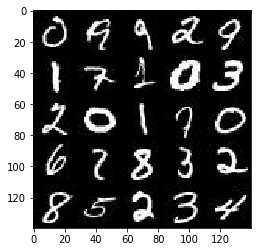

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

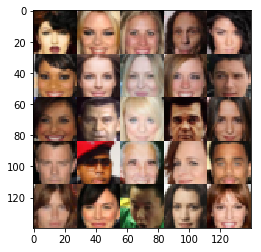

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, ())

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        # First convolution
        conv_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        # Leaky ReLU
        conv_1 = tf.maximum(conv_1, alpha * conv_1)
        # Size is now 14x14x64
        
        # Second convolution
        conv_2 = tf.layers.conv2d(conv_1, 128, 5, strides=2, padding='same', activation=None, use_bias=False)
        conv_2 = tf.layers.batch_normalization(conv_2, training=True)
        conv_2 = tf.maximum(conv_2, alpha * conv_2)
        # Size is now 7x7x128
        
        # Third convolution
        conv_3 = tf.layers.conv2d(conv_2, 256, 5, strides=2, padding='same', activation=None, use_bias=False)
        conv_3 = tf.layers.batch_normalization(conv_3, training=True)
        conv_3 = tf.maximum(conv_3, alpha * conv_3)
        # Size is now 4x4x256
        
        flat = tf.reshape(conv_3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256, activation=None, use_bias=False)
        x = tf.reshape(x, [-1, 7, 7, 256])
        # Batch normalization
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x, alpha * x)
        
        # First convolutional layer, with shape 14x14x128
        conv_1 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', activation=None, use_bias=False)
        # Batch normalization
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        # Leaky ReLU
        conv_1 = tf.maximum(conv_1, alpha * conv_1)
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(conv_1, out_channel_dim, 5, strides=2, padding='same', activation=None, use_bias=False)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learn_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    losses = []
    steps = 0
    
    # TODO: Build Model
    if data_image_mode == "L":
        out_channel_dim = 1
    else:
        out_channel_dim = 3
        
    real_inputs, z_inputs, learning_rate = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, out_channel_dim, alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learning_rate: learn_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learning_rate: learn_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 72, z_inputs, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 21.2840
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 18.0596
Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 11.3044
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 2.3397
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 2.1688
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 2.0048
Epoch 1/2... Discriminator Loss: 1.6949... Generator Loss: 0.2843
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 5.1705... Generator Loss: 9.2592
Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 1.4304


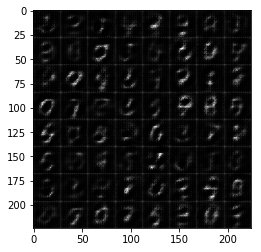

Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 1.7635
Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 0.1073... Generator Loss: 3.0515
Epoch 1/2... Discriminator Loss: 0.1321... Generator Loss: 2.9876
Epoch 1/2... Discriminator Loss: 0.0534... Generator Loss: 4.0786
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 4.1291
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 2.4006... Generator Loss: 0.1320
Epoch 1/2... Discriminator Loss: 0.2552... Generator Loss: 2.2370
Epoch 1/2... Discriminator Loss: 0.1484... Generator Loss: 2.4765


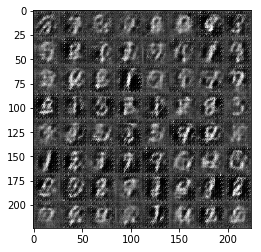

Epoch 1/2... Discriminator Loss: 0.0496... Generator Loss: 5.8554
Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 4.4842
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.6745
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 1.4819
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 0.1630... Generator Loss: 7.5298
Epoch 1/2... Discriminator Loss: 1.7218... Generator Loss: 0.2591
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 0.1356... Generator Loss: 7.0617


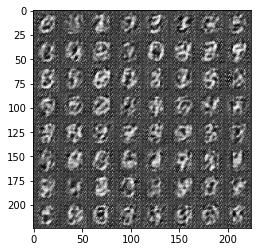

Epoch 1/2... Discriminator Loss: 2.0859... Generator Loss: 4.9209
Epoch 1/2... Discriminator Loss: 0.2504... Generator Loss: 5.5739
Epoch 1/2... Discriminator Loss: 0.0413... Generator Loss: 5.8521
Epoch 1/2... Discriminator Loss: 2.6367... Generator Loss: 0.0900
Epoch 1/2... Discriminator Loss: 0.3220... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.0615
Epoch 1/2... Discriminator Loss: 0.0538... Generator Loss: 4.1829
Epoch 1/2... Discriminator Loss: 0.0156... Generator Loss: 5.5361
Epoch 1/2... Discriminator Loss: 0.0420... Generator Loss: 4.6507


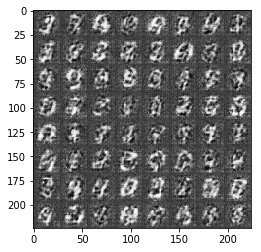

Epoch 1/2... Discriminator Loss: 0.0442... Generator Loss: 6.7067
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 6.1793
Epoch 1/2... Discriminator Loss: 0.0400... Generator Loss: 3.8383
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 5.1795
Epoch 1/2... Discriminator Loss: 0.0177... Generator Loss: 7.9210
Epoch 1/2... Discriminator Loss: 0.2044... Generator Loss: 1.9332
Epoch 2/2... Discriminator Loss: 0.0222... Generator Loss: 10.9262
Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 10.6190
Epoch 2/2... Discriminator Loss: 1.5709... Generator Loss: 0.3539
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.4453


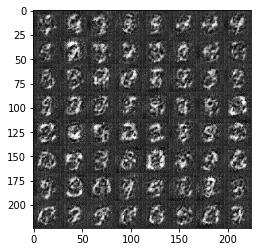

Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.8557
Epoch 2/2... Discriminator Loss: 2.2338... Generator Loss: 4.7653
Epoch 2/2... Discriminator Loss: 0.5319... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 0.1909... Generator Loss: 2.1282
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 0.5090... Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.3114... Generator Loss: 1.6514
Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 2.3032


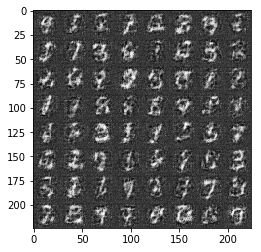

Epoch 2/2... Discriminator Loss: 0.2192... Generator Loss: 1.9574
Epoch 2/2... Discriminator Loss: 0.0676... Generator Loss: 3.3499
Epoch 2/2... Discriminator Loss: 0.0344... Generator Loss: 4.6071
Epoch 2/2... Discriminator Loss: 0.0425... Generator Loss: 3.8241
Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 3.8073
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 4.0840
Epoch 2/2... Discriminator Loss: 0.0439... Generator Loss: 3.8792
Epoch 2/2... Discriminator Loss: 0.0395... Generator Loss: 3.7546
Epoch 2/2... Discriminator Loss: 0.0509... Generator Loss: 3.4365
Epoch 2/2... Discriminator Loss: 0.0721... Generator Loss: 3.0154


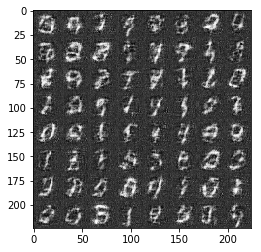

Epoch 2/2... Discriminator Loss: 0.0251... Generator Loss: 4.2219
Epoch 2/2... Discriminator Loss: 0.0167... Generator Loss: 5.9443
Epoch 2/2... Discriminator Loss: 0.0180... Generator Loss: 4.7955
Epoch 2/2... Discriminator Loss: 0.0191... Generator Loss: 5.8642
Epoch 2/2... Discriminator Loss: 3.4300... Generator Loss: 3.8226
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.5362
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.3578
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 2.6567


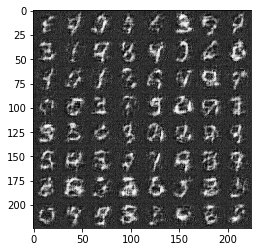

Epoch 2/2... Discriminator Loss: 1.9447... Generator Loss: 4.1597
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 2.9237
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 2.3573
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.4916
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 1.6653
Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 2.4997
Epoch 2/2... Discriminator Loss: 0.4056... Generator Loss: 1.8072
Epoch 2/2... Discriminator Loss: 0.3251... Generator Loss: 1.8199
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.1496


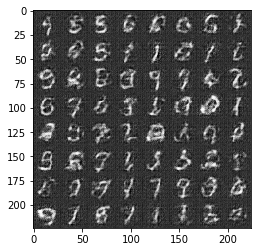

Epoch 2/2... Discriminator Loss: 0.4098... Generator Loss: 1.5788
Epoch 2/2... Discriminator Loss: 0.2305... Generator Loss: 2.2193
Epoch 2/2... Discriminator Loss: 0.1943... Generator Loss: 2.2470


In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 2.1466
Epoch 1/1... Discriminator Loss: 0.2058... Generator Loss: 2.3255
Epoch 1/1... Discriminator Loss: 0.1702... Generator Loss: 2.9833
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 1.8120... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 0.2877... Generator Loss: 2.2408
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 1.9396
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 3.7132


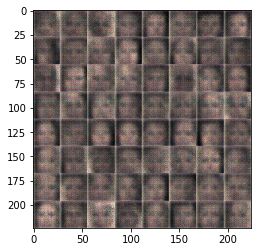

Epoch 1/1... Discriminator Loss: 1.7315... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 3.2414
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 2.8951
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 0.1436... Generator Loss: 2.9412
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 2.6666
Epoch 1/1... Discriminator Loss: 2.1457... Generator Loss: 0.1572
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.5320


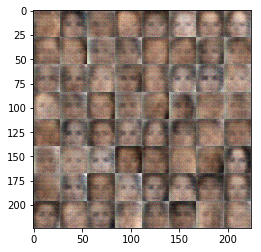

Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 2.4546
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 3.9208
Epoch 1/1... Discriminator Loss: 0.2482... Generator Loss: 3.5253
Epoch 1/1... Discriminator Loss: 0.2998... Generator Loss: 4.3328
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 2.5298
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 6.6422
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.5151


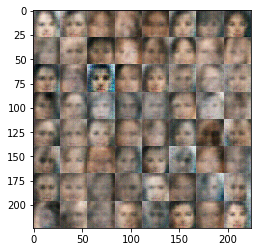

Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 6.7416
Epoch 1/1... Discriminator Loss: 3.7122... Generator Loss: 7.7210
Epoch 1/1... Discriminator Loss: 0.1729... Generator Loss: 2.6914
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 6.1956
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 5.6023
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 2.1059
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 8.5396
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 7.3787
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.0486


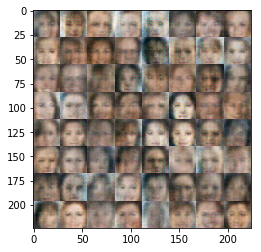

Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 8.9472
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 10.8106
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 12.1997
Epoch 1/1... Discriminator Loss: 0.2710... Generator Loss: 11.7705
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 4.7600
Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 2.7930
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 10.8711
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.2522
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 9.9237


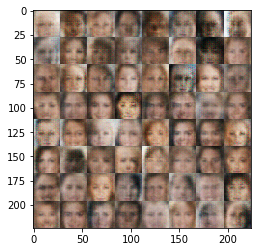

Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 10.5844
Epoch 1/1... Discriminator Loss: 0.0605... Generator Loss: 7.0878
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 6.9642
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 8.3141
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 6.9490
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 10.2931
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 8.7756
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 10.9777
Epoch 1/1... Discriminator Loss: 2.0818... Generator Loss: 0.1637
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 1.2748


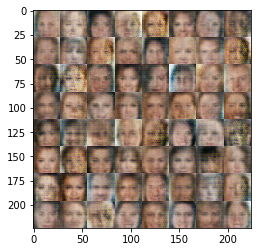

Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 6.1255
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 9.2626
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 7.4470
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 3.5432
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 6.9066
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 3.6501
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 12.4209
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 10.7304
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 7.0348


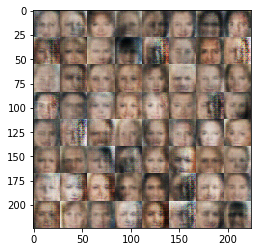

Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 7.1400
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.8650
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 10.5749
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 3.4043
Epoch 1/1... Discriminator Loss: 0.0985... Generator Loss: 2.8249
Epoch 1/1... Discriminator Loss: 0.2920... Generator Loss: 1.6167
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 5.9661
Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 13.4931
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 8.3856


In [34]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.